In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

/var/folders/4_/5vc_xrv55mjf8lnnrnlx1vz40000gn/T/ipykernel_15812/2854121047.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('label').apply(lambda x: x.sample(max_class_count, replace=True)).reset_index(drop=True)
/var/folders/4_/5vc_xrv55mjf8lnnrnlx1vz40000gn/T/ipykernel_15812/2854121047.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('label'

label
cruciate-ligament-minor     9805
cruciate-ligament-urgent    9805
meniskus-minor              9805
meniskus-urgent             9805
other-minor                 9805
Name: count, dtype: int64


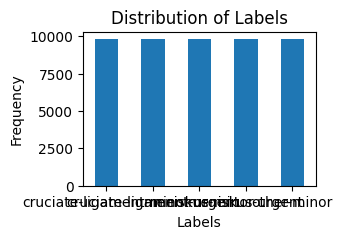

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

# Oversampling for training data
max_class_count = df_train['label'].value_counts().max()
df_train = df_train.groupby('label').apply(lambda x: x.sample(max_class_count, replace=True)).reset_index(drop=True)

# Oversampling for validation data
max_class_count = df_valid['label'].value_counts().max()
df_valid = df_valid.groupby('label').apply(lambda x: x.sample(max_class_count, replace=True)).reset_index(drop=True)

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "oversampling"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-07-25 22:09:16.004831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-25 22:09:16.004873: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-25 22:09:16.004903: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-25 22:09:16.004948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 22:09:16.004989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [5]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-07-25 22:09:16.703849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1533/1533 ━━━━━━━━━━━━━━━━━━━━ 203s 131ms/step - accuracy: 0.4996 - auc: 0.8212 - f1_score: 0.4860 - loss: 1.1143 - val_accuracy: 0.5550 - val_auc: 0.8088 - val_f1_score: 0.5648 - val_loss: 1.5480
Epoch 2/15
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 202s 132ms/step - accuracy: 0.8139 - auc: 0.9685 - f1_score: 0.8129 - loss: 0.4927 - val_accuracy: 0.6034 - val_auc: 0.8309 - val_f1_score: 0.6109 - val_loss: 1.6403
Epoch 3/15
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 204s 133ms/step - accuracy: 0.8810 - auc: 0.9859 - f1_score: 0.8797 - loss: 0.3226 - val_accuracy: 0.6193 - val_auc: 0.8345 - val_f1_score: 0.6273 - val_loss: 1.8877
Epoch 4/15
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 205s 134ms/step - accuracy: 0.9113 - auc: 0.9918 - f1_score: 0.9106 - loss: 0.2401 - val_accuracy: 0.6300 - val_auc: 0.8333 - val_f1_score: 0.6418 - val_loss: 2.0147
Epoch 5/15
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 205s 134ms/step - accuracy: 0.9381 - auc: 0.9956 - f1_score: 0.9378 - loss: 0.1701 - val_accuracy: 0.6389 - val_auc: 0.8358 - val_f1_scor

In [7]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/oversampling/oversampling.h5
Data saved


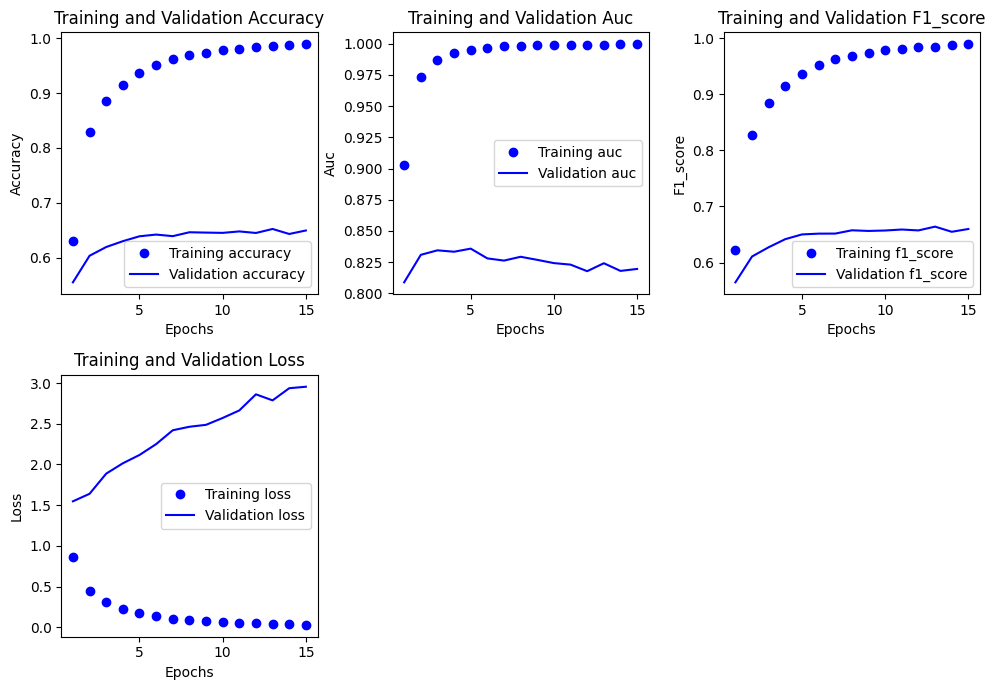

In [8]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step


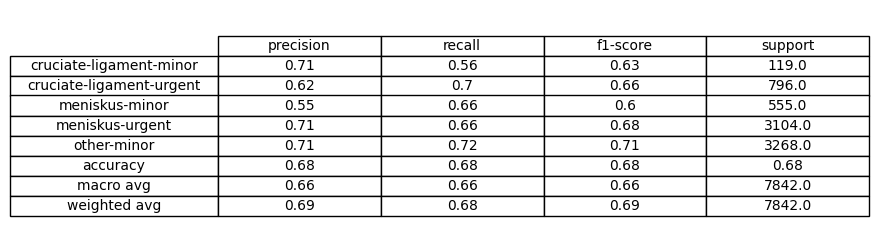

In [9]:
eval(model, test_padded, test_labels, label_encoder)